In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
class Network:
  def __init__(
    self,
    k_tunnels,
    n_nodes,
    m_edges,
    underlay_service_rates,
    external_arrival_rates,
    tunnel_edge2node_adjacencies
  ):
    self.k_tunnels = k_tunnels
    self.n_nodes = n_nodes
    self.m_edges = m_edges
    self.underlay_service_rates = underlay_service_rates
    self.external_arrival_rates = external_arrival_rates
    self.tunnel_edge2node_adjacencies = tunnel_edge2node_adjacencies
    self.time = 0

  def reset(self):
    self.queue_backlogs = np.zeros([self.k_tunnels, self.n_nodes,])
    self.time = 0
    return self.queue_backlogs, self.time

  def act(self):
    return

  def step(self, overlay_offered_rates):

    # handle each tunnel as though it is a different network
    for tt in range(self.k_tunnels):
      # if(tt == 1):
      #   print('t = ' + str(self.time))
      #   print('Q(t) = ' + str(self.queue_backlogs[tt,:]))

      # external arrivals
      external_arrivals = np.random.poisson(self.external_arrival_rates[tt,:], self.n_nodes)
      self.queue_backlogs[tt,:] += external_arrivals

      # flows along edges
      all_offered_rates = np.random.poisson(self.underlay_service_rates[tt,:], self.m_edges) + overlay_offered_rates[tt,:]

      # make sure flows are not greater than current queue size
      actual_rates = np.min(np.vstack(((self.tunnel_edge2node_adjacencies[tt,:,:].T < 0)@self.queue_backlogs[tt,:], all_offered_rates)), axis=0)

      # apply flows
      self.queue_backlogs[tt,:] += self.tunnel_edge2node_adjacencies[tt,:,:]@actual_rates
      self.queue_backlogs[tt, self.queue_backlogs[tt,:] < 0] = 0
      # if(tt == 1):
      #   print('External arrivals = ' + str(external_arrivals))
      #   print('Offered rates = ' + str(all_offered_rates))
      #   print('Actual rates = ' + str(actual_rates))
      #   print('Q(t+1) = ' + str(self.queue_backlogs[tt,:]))
      #   print(' ')

      # the destination queue is a sink
      self.queue_backlogs[tt, -1] = 0

    self.time += 1
    return self.queue_backlogs, self.time

In [ ]:
n_nodes = 5
m_edges = 5
k_tunnels = 2

underlay_service_rates = np.zeros([k_tunnels, m_edges, ])
underlay_service_rates[0,:] = np.array([0,1,0,1,1])
underlay_service_rates[1,:] = np.array([0,0,1,0,1])

external_arrival_rates = np.zeros([k_tunnels, n_nodes, ])
external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])

In [ ]:
tunnel_edge2node_adjacencies = np.zeros([k_tunnels, n_nodes, m_edges])
tunnel_edge2node_adjacencies[0,:,:] = np.array([[-1,0,0,0,0],
                                [1,-1,0,0,0],
                                [0,1,0,-1,0],
                                [0,0,0,1,-1],
                                [0,0,0,0,1]])
tunnel_edge2node_adjacencies[1,:,:] = np.array([[-1,0,0,0,0],
                                [1,0,-1,0,0],
                                [0,0,0,0,0],
                                [0,0,1,0,-1],
                                [0,0,0,0,1]])

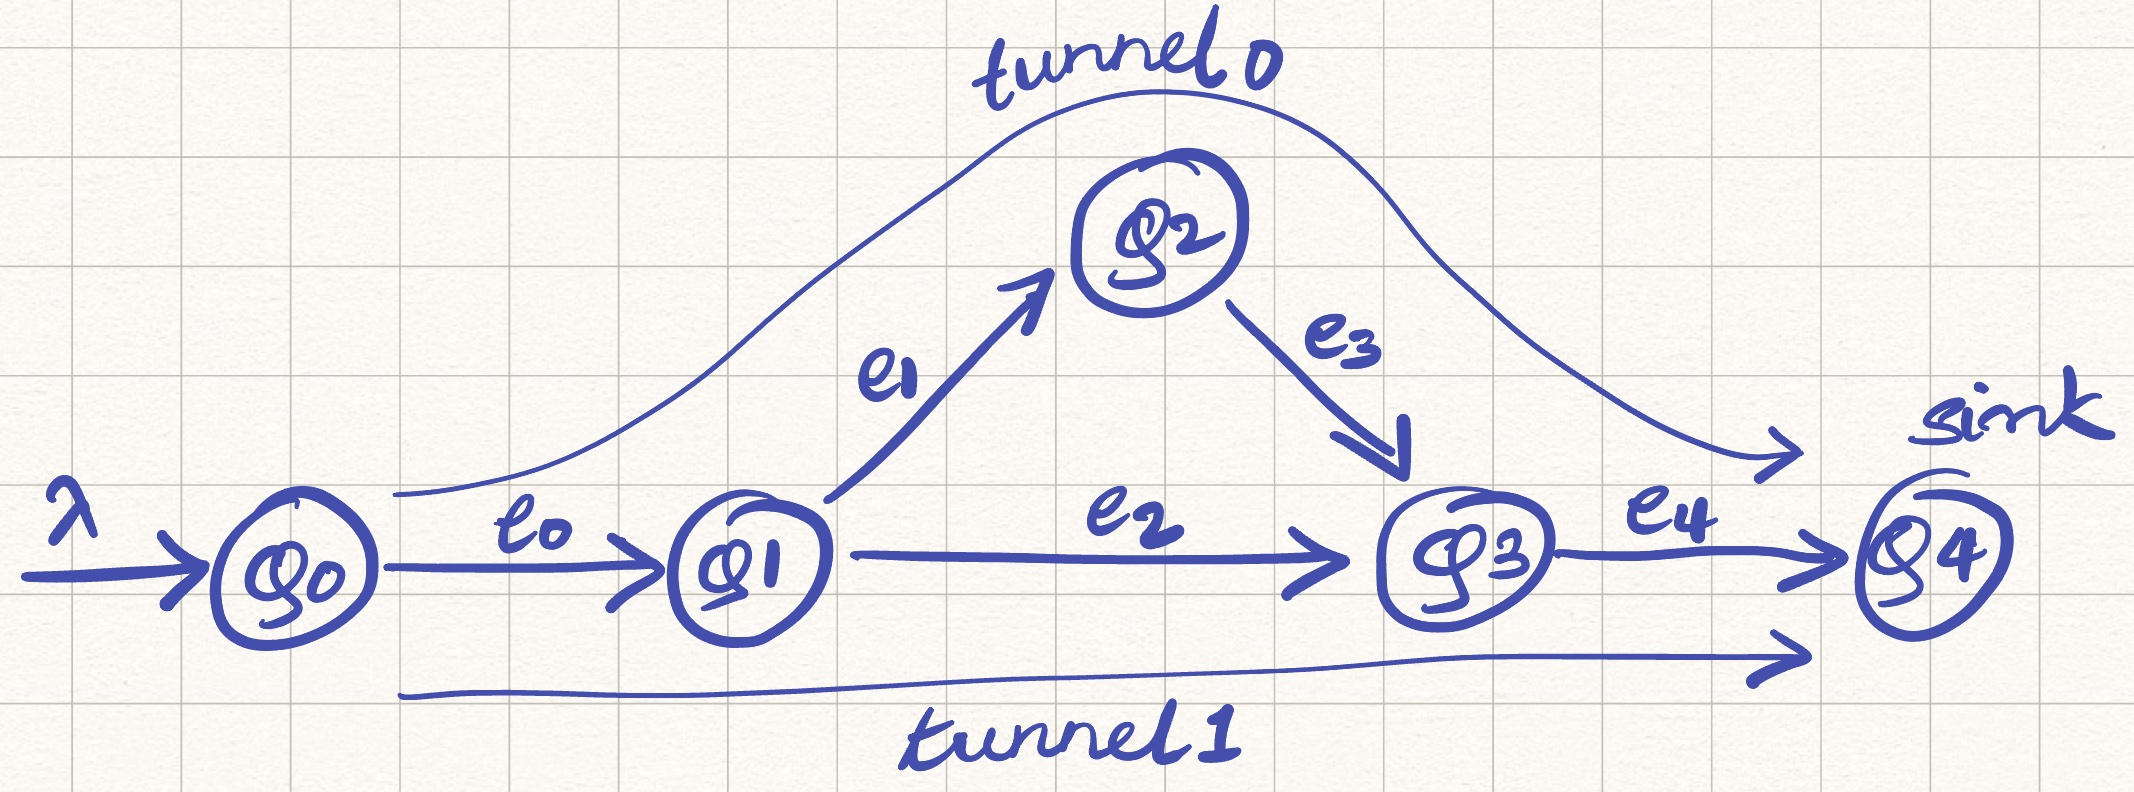

In [ ]:
myNetwork = Network(k_tunnels,
    n_nodes,
    m_edges,
    underlay_service_rates,
    external_arrival_rates,
    tunnel_edge2node_adjacencies)

In [ ]:
np.random.seed(5)

queue_backlogs, time = myNetwork.reset()

total_time = 100000
total_queuebacklogs = np.zeros([total_time, n_nodes])
total_queuebacklogs[time, : ] = np.sum(queue_backlogs, axis=0)
total_tunnelbacklogs = np.zeros([total_time, k_tunnels])

while(time < total_time-1):
  overlay_offered_rates = np.zeros([k_tunnels, m_edges,])
  overlay_offered_rates[0,:] = np.random.poisson(np.array([1,0,0,0,0]), m_edges)
  overlay_offered_rates[1,:] = np.random.poisson(np.array([1,0,0,0,0]), m_edges)

  queue_backlogs, time = myNetwork.step(overlay_offered_rates)
  total_queuebacklogs[time, : ] = np.sum(queue_backlogs, axis=0)
  total_tunnelbacklogs[time, :] = np.sum(queue_backlogs, axis=1)

In [ ]:
# plt.plot(total_queuebacklogs[:,0], label='Q0')
# plt.plot(total_queuebacklogs[:,1], label='Q1')
# plt.plot(total_queuebacklogs[:,2], label='Q2')
# plt.plot(total_queuebacklogs[:,3], label='Q3')
# plt.legend()

In [ ]:
def running_average(arr, window_size = 1000):
    cumsum = np.cumsum(np.insert(arr, 0, 0))
    running_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return running_avg

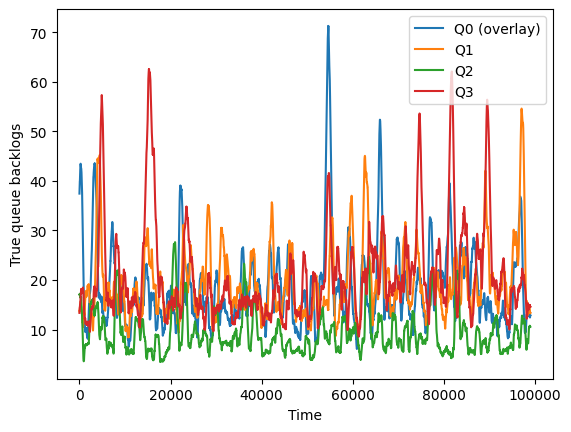

In [ ]:
plt.plot(running_average(total_queuebacklogs[:,0]), label='Q0 (overlay)')
plt.plot(running_average(total_queuebacklogs[:,1]), label='Q1')
plt.plot(running_average(total_queuebacklogs[:,2]), label='Q2')
plt.plot(running_average(total_queuebacklogs[:,3]), label='Q3')
plt.xlabel('Time')
plt.ylabel('True queue backlogs')
plt.legend()
plt.show()

In [ ]:
print(np.cov(total_queuebacklogs.T))

[[221.88122207  -8.9599505    2.20411714   8.62984007   0.        ]
 [ -8.9599505  191.42958842  -6.16958858   3.05158364   0.        ]
 [  2.20411714  -6.16958858  80.64079853  -7.80003688   0.        ]
 [  8.62984007   3.05158364  -7.80003688 234.25511201   0.        ]
 [  0.           0.           0.           0.           0.        ]]


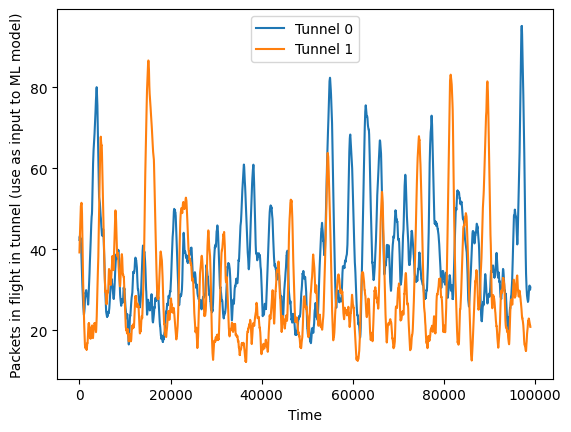

In [ ]:
plt.plot(running_average(total_tunnelbacklogs[:,0]), label='Tunnel 0')
plt.plot(running_average(total_tunnelbacklogs[:,1]), label='Tunnel 1')
plt.legend()
plt.ylabel('Packets in flight in tunnel (use as input to ML model)')
plt.xlabel('Time')
plt.show()

In [ ]:
X = total_tunnelbacklogs

In [ ]:
tunnel0backlog = total_queuebacklogs[:,0] + total_queuebacklogs[:,1] + total_queuebacklogs[:,2] + total_queuebacklogs[:,3]
tunnel1backlog = total_queuebacklogs[:,0] + total_queuebacklogs[:,1] + total_queuebacklogs[:,3]

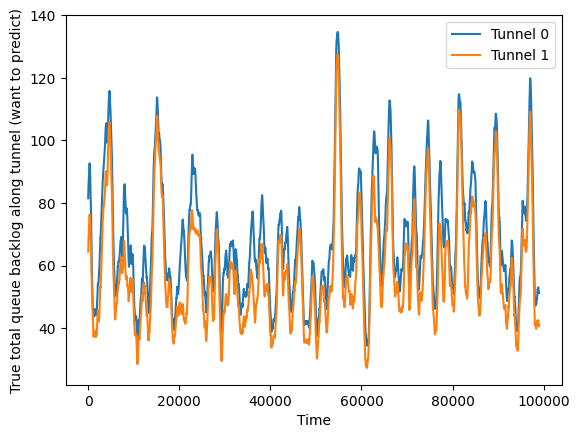

In [ ]:
plt.plot(running_average(tunnel0backlog), label='Tunnel 0')
plt.plot(running_average(tunnel1backlog), label='Tunnel 1')
plt.legend()
plt.ylabel('True total queue backlog along tunnel (want to predict)')
plt.xlabel('Time')
plt.show()

For our topology, the total queue backlog in tunnel 0 = total queue backlog in tunnel 1 + queue backlog in node 2. So, the total queue backlogs look very similar.

In [ ]:
print(np.mean(np.sum(total_tunnelbacklogs,axis=1) != tunnel0backlog))

0.0


# Tunnel 1 Predictions

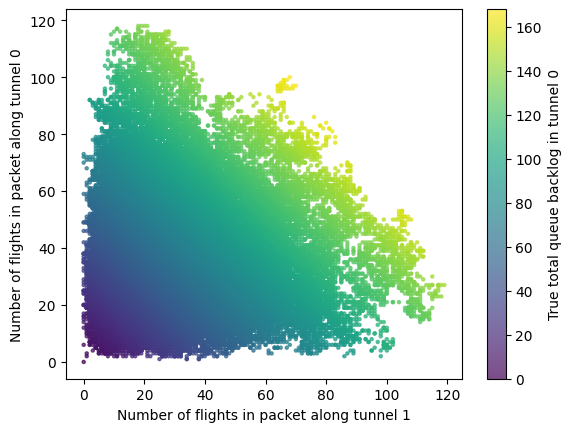

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=tunnel0backlog, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('True total queue backlog in tunnel 0')

In [ ]:
X = total_tunnelbacklogs
Y = tunnel0backlog
A = np.linalg.inv(X.T@X)@X.T@Y
print('Learned A = ', A)
Y_predicted = X@A
print('RMS error = ', np.sqrt(np.mean((Y_predicted-Y)**2)))
print('Relative error = ', 100*np.mean(np.abs(Y_predicted-Y)[Y>0]/Y[Y>0]), '%')

Learned A =  [1. 1.]
RMS error =  1.5826883381276913e-14
Relative error =  2.1365208544094487e-14 %


Prediction is perfect because prediction is easy. The total backlog in tunnel 0 is simply sum of packets in flights in tunnel 0 and 1.

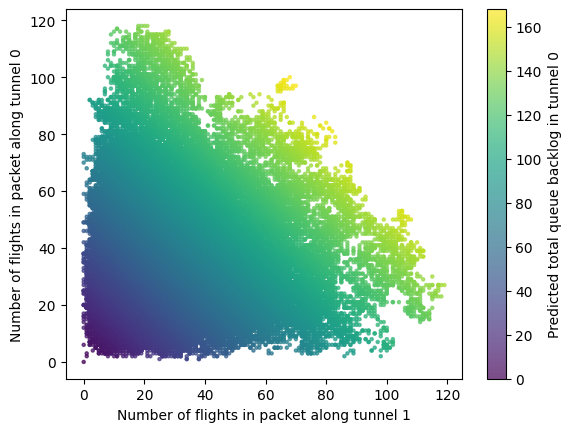

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=Y_predicted, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('Predicted total queue backlog in tunnel 0')

# Tunnel 2 Predictions

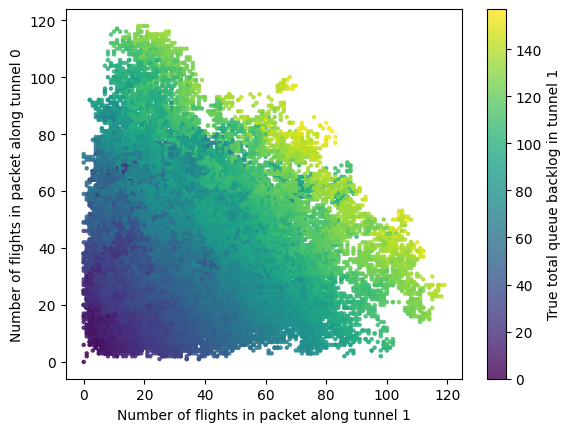

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=tunnel1backlog, cmap='viridis', s=5, alpha=0.8)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('True total queue backlog in tunnel 1')

In [ ]:
X = total_tunnelbacklogs
Y = tunnel1backlog
A = np.linalg.inv(X.T@X)@X.T@Y
print('Learned A = ', A)
Y_predicted = X@A
print('RMS error = ', np.sqrt(np.mean((Y_predicted-Y)**2)))
print('Relative error = ', 100*np.mean(np.abs(Y_predicted-Y)[Y>0]/Y[Y>0]), '%')

Learned A =  [0.77166856 0.98515731]
RMS error =  8.130121314392664
Relative error =  12.279043512004495 %


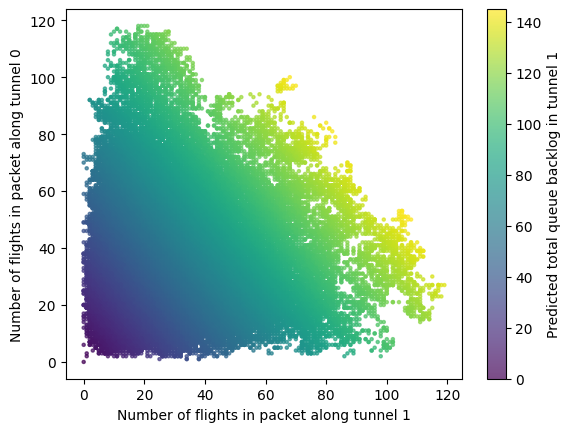

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=Y_predicted, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('Predicted total queue backlog in tunnel 1')

In [ ]:
X = total_tunnelbacklogs
X_augmented = np.hstack((np.ones([X.shape[0],1]), X))
X_augmented = np.hstack((X_augmented, X**2, X**3))
# X_augmented = np.hstack((X_augmented, np.cos(X)))
# X_augmented = np.hstack((X_augmented, np.sin(X)))
# X_augmented = np.hstack((X_augmented, np.exp(X)))

Y = tunnel1backlog
A = np.linalg.inv(X_augmented.T@X_augmented)@X_augmented.T@Y
print('Learned A = ', A)
Y_predicted = X_augmented@A
print('RMS error = ', np.sqrt(np.mean((Y_predicted-Y)**2)))
print('Relative error = ', 100*np.mean(np.abs(Y_predicted-Y)[Y>0]/Y[Y>0]), '%')

Learned A =  [-1.31330569e+00  9.04233452e-01  9.83203014e-01 -5.11585138e-03
  2.87918222e-04  4.84442098e-05  8.37600549e-08]
RMS error =  7.975573185945355
Relative error =  12.182549779408612 %


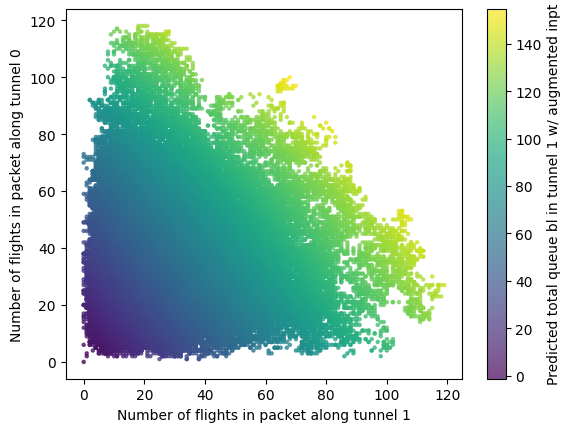

In [ ]:
plt.scatter(X[:, 1], X[:, 0], c=Y_predicted, cmap='viridis', s=5, alpha=0.7)
plt.xlabel('Number of flights in packet along tunnel 1')
plt.ylabel('Number of flights in packet along tunnel 0')
cbar = plt.colorbar()
cbar.set_label('Predicted total queue bl in tunnel 1 w/ augmented inpt')